In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer
import seaborn as sns

# Tokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [3]:
def verify_token_mapping(context, answer_text, answer_start_char, start_token_idx, end_token_idx, verbose=False):
    """
    Verifies that the token indices correctly map to the original answer text using BERT tokenizer.
    """
    # Tokenize context with BERT tokenizer
    encoding = tokenizer(context, return_offsets_mapping=True)
    tokens = encoding.tokens()
    offset_mapping = encoding["offset_mapping"]
 
    # Get the answer text based on token indices
    if start_token_idx >= len(tokens) or end_token_idx >= len(tokens):
        if verbose:
            print(f"Error: Token indices ({start_token_idx}, {end_token_idx}) out of bounds. Max: {len(tokens)-1}")
        return False
 
    # Get the character span from token indices
    start_char = offset_mapping[start_token_idx][0]
    end_char = offset_mapping[end_token_idx][1]
    token_answer = context[start_char:end_char]
 
    # Normalize both answers for comparison
    original_normalized = ' '.join(answer_text.lower().split())
    token_normalized = ' '.join(token_answer.lower().split())
 
    # Check character-level context
    context_substring = context[answer_start_char:answer_start_char+len(answer_text)]
    context_normalized = ' '.join(context_substring.lower().split())
 
    is_exact_match = token_normalized == original_normalized
    is_substring = token_normalized in original_normalized or original_normalized in token_normalized
 
    if verbose:
        print(f"Original answer: '{answer_text}'")
        print(f"Context substring: '{context_substring}'")
        print(f"Token-based answer: '{token_answer}'")
        print(f"Char indices: start={answer_start_char}, end={answer_start_char+len(answer_text)-1}")
        print(f"Token indices: start={start_token_idx}, end={end_token_idx}")
        print(f"Match status: {'EXACT MATCH' if is_exact_match else ('PARTIAL MATCH' if is_substring else 'NO MATCH')}")
 
        if not is_exact_match:
            # print("\nToken boundaries near answer:")
            for i in range(max(0, start_token_idx-2), min(len(tokens), end_token_idx+3)):
                if i >= 0 and i < len(offset_mapping):
                    start, end = offset_mapping[i]
                    highlight = "→" if start_token_idx <= i <= end_token_idx else " "
                    print(f"{highlight} Token {i}: '{tokens[i]}' at chars [{start}:{end}]")
 
    return is_exact_match

In [4]:
def align_character_to_token_indices(context, answer_start_char, answer_text):
    """
    Maps character-level indices to BERT token-level indices.
    """
    encoding = tokenizer(context, return_offsets_mapping=True)
    offset_mapping = encoding["offset_mapping"]
    answer_end_char = answer_start_char + len(answer_text)
 
    # Find tokens that overlap with the answer span
    start_token_idx = None
    end_token_idx = None
 
    for i, (start, end) in enumerate(offset_mapping):
        if start <= answer_start_char < end:
            start_token_idx = i
        if start < answer_end_char <= end:
            end_token_idx = i
            break
 
    # If we didn't find exact matches, find the closest tokens
    if start_token_idx is None:
        for i, (start, end) in enumerate(offset_mapping):
            if answer_start_char < end:
                start_token_idx = i
                break
 
    if end_token_idx is None:
        for i, (start, end) in reversed(list(enumerate(offset_mapping))):
            if start < answer_end_char:
                end_token_idx = i
                break
 
    # Ensure we have valid indices
    if start_token_idx is None:
        start_token_idx = 0
    if end_token_idx is None:
        end_token_idx = len(offset_mapping) - 1
 
    # Ensure end_token_idx is at least start_token_idx
    end_token_idx = max(start_token_idx, end_token_idx)
 
    return start_token_idx, end_token_idx

# Load Dataset

In [5]:
context_token_lens = []
question_lens = []
answer_char_starts = []
answer_char_lens = []
valid_mappings = 0
invalid_mappings = 0

def load_squad_subset(path='/kaggle/input/milestone2data/train-v1.1.json', max_samples=10000, max_context_tokens=200):
    global context_token_lens, question_lens, answer_char_starts, answer_char_lens
    global valid_mappings, invalid_mappings

    with open(path, 'r') as f:
        data = json.load(f)['data']

    samples = []
    total_count = 0

    for article in data:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            tokenized_context = tokenizer.tokenize(context)
            context_len = len(tokenized_context)
            context_token_lens.append(context_len)

            if context_len > max_context_tokens:
                continue

            for qa in paragraph['qas']:
                if len(qa['answers']) == 0:
                    continue

                total_count += 1
                question = qa['question']
                answer_text = qa['answers'][0]['text']
                answer_start_char = qa['answers'][0]['answer_start']
                answer_end_char = answer_start_char + len(answer_text)

                question_lens.append(len(tokenizer.tokenize(question)))
                answer_char_starts.append(answer_start_char)
                answer_char_lens.append(len(answer_text))

                start_token, end_token = align_character_to_token_indices(
                    context, answer_start_char, answer_text)

                is_valid = verify_token_mapping(
                    context, answer_text, answer_start_char,
                    start_token, end_token,
                    verbose=(total_count <= 3)
                )

                if is_valid:
                    valid_mappings += 1
                    samples.append((context, question, start_token, end_token,
                                    answer_start_char, answer_end_char))
                    if len(samples) >= max_samples:
                        print(f"Mapping accuracy: {valid_mappings}/{total_count} = {valid_mappings/total_count:.2%}")
                        return samples
                else:
                    invalid_mappings += 1

    print(f"Mapping accuracy: {valid_mappings}/{total_count} = {valid_mappings/total_count:.2%}")
    return samples


In [6]:
def plot_dataset_insights():
    sns.set(style='whitegrid')

    plt.figure(figsize=(12, 6))
    sns.histplot(context_token_lens, bins=50, kde=True)
    plt.title("Context Token Lengths (before filtering)")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(question_lens, bins=30, kde=True)
    plt.title("Question Token Lengths")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(answer_char_starts, bins=50, kde=True)
    plt.title("Answer Start Character Position in Context")
    plt.xlabel("Start Character Index")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(answer_char_lens, bins=30, kde=True)
    plt.title("Answer Lengths (Characters)")
    plt.xlabel("Answer Length")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.pie([valid_mappings, invalid_mappings],
            labels=["Valid Mappings", "Invalid Mappings"],
            autopct='%1.1f%%', startangle=140)
    plt.title("Token Mapping Validity")
    plt.show()


# Build Vocab

In [7]:
def build_vocab(samples, min_freq=1):
    counter = Counter()
    for context, question, *_ in samples:
        counter.update(tokenizer.tokenize(context))
        counter.update(tokenizer.tokenize(question))
    vocab = {'[PAD]': 0, '[UNK]': 1, '[SEP]': 2, '[CLS]': 3}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Load Glove Embeddings

In [8]:
def load_glove(vocab, dim=300, glove_path='/kaggle/input/milestone2data/glove.6B.300d.txt'):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vec
 
    embedding_matrix = np.zeros((max(vocab.values()) + 1, dim))
    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = embeddings[word]
        else:
            # For subword tokens, try to find embeddings for the base word
            if word.startswith('##'):
                base_word = word[2:]
                if base_word in embeddings:
                    embedding_matrix[idx] = embeddings[base_word]
                    continue
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(dim,))
    return torch.tensor(embedding_matrix, dtype=torch.float)

In [9]:
def load_fasttext(vocab, path='/kaggle/input/fasttext/wiki-news-300d-1M-subword.vec', dim=300):
    print("Loading FastText embeddings...")
    embeddings = {}
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        next(f)  # skip header
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vec

    # Create embedding matrix
    embedding_matrix = np.zeros((len(vocab), dim))
    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = embeddings[word]
        elif word.startswith('##') and word[2:] in embeddings:
            embedding_matrix[idx] = embeddings[word[2:]]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(dim,))
    
    return torch.tensor(embedding_matrix, dtype=torch.float)


# Squad Dataset

In [10]:
class SquadExtractiveDataset(Dataset):
    def __init__(self, samples, vocab, max_len=300):
        self.samples = samples
        self.vocab = vocab
        self.max_len = max_len
        self.tokenizer = tokenizer
 
    def encode(self, text):
        tokens = self.tokenizer.tokenize(text)
        return [self.vocab.get(tok, self.vocab['[UNK]']) for tok in tokens]
 
    def pad(self, seq):
        return seq[:self.max_len] + [self.vocab['[PAD]']] * max(0, self.max_len - len(seq))
 
    def __getitem__(self, idx):
        context, question, start, end, *_ = self.samples[idx]
        # Add [CLS] and [SEP] tokens
        x = [self.vocab['[CLS]']] + self.encode(question) + [self.vocab['[SEP]']] + self.encode(context)
        x = self.pad(x)
 
        # Adjust start and end positions for the added [CLS] token
        question_len = len(self.tokenizer.tokenize(question))
        start += (1 + question_len + 1)  # [CLS] + question + [SEP]
        end += (1 + question_len + 1)
 
        return torch.tensor(x), torch.tensor(start), torch.tensor(end)
 
    def __len__(self):
        return len(self.samples)

# Extractive RNN Model

In [11]:
class ExtractiveQARNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, embedding_matrix, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.dropout = nn.Dropout(p=dropout)
        self.encoder = nn.GRU(emb_dim, hidden_dim, num_layers=3, bidirectional=True, batch_first=True)
        self.start_fc = nn.Linear(hidden_dim * 2, 1)
        self.end_fc = nn.Linear(hidden_dim * 2, 1)
 
    def forward(self, x):
        emb = self.embedding(x)
        outputs, _ = self.encoder(self.dropout(emb))
        start_logits = self.start_fc(outputs).squeeze(-1)
        end_logits = self.end_fc(outputs).squeeze(-1)
        return start_logits, end_logits

# Evaluation Metric

In [12]:
def compute_token_f1(pred_start, pred_end, true_start, true_end):
    pred_set = set(range(pred_start, pred_end + 1))
    true_set = set(range(true_start, true_end + 1))
    if len(pred_set) == 0 or len(true_set) == 0:
        return 0.0
    intersection = pred_set & true_set
    if not intersection:
        return 0.0
    precision = len(intersection) / len(pred_set)
    recall = len(intersection) / len(true_set)
    return 2 * precision * recall / (precision + recall)

# Training

In [13]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total = 0
    exact_match = 0
    f1_total = 0

    for x, start, end in tqdm(dataloader, desc='Training'):
        x, start, end = x.to(device), start.to(device), end.to(device)
        optimizer.zero_grad()
        start_logits, end_logits = model(x)
        loss = criterion(start_logits, start) + criterion(end_logits, end)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred_start = torch.argmax(start_logits, dim=1)
        pred_end = torch.argmax(end_logits, dim=1)

        for i in range(x.size(0)):
            ps, pe = pred_start[i].item(), pred_end[i].item()
            ts, te = start[i].item(), end[i].item()

            em = int(ps == ts and pe == te)
            f1 = compute_token_f1(ps, pe, ts, te)

            exact_match += em
            f1_total += f1
            total += 1

    avg_loss = total_loss / len(dataloader)
    em_score = exact_match / total
    f1_score = f1_total / total

    return avg_loss, em_score, f1_score

# Evaluation

In [14]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total = 0
    exact_match = 0
    f1_total = 0

    with torch.no_grad():
        for x, start, end in tqdm(dataloader, desc='Evaluating'):
            x, start, end = x.to(device), start.to(device), end.to(device)
            start_logits, end_logits = model(x)
            loss = criterion(start_logits, start) + criterion(end_logits, end)
            total_loss += loss.item()

            pred_start = torch.argmax(start_logits, dim=1)
            pred_end = torch.argmax(end_logits, dim=1)

            for i in range(x.size(0)):
                ps, pe = pred_start[i].item(), pred_end[i].item()
                ts, te = start[i].item(), end[i].item()

                em = int(ps == ts and pe == te)
                f1 = compute_token_f1(ps, pe, ts, te)

                exact_match += em
                f1_total += f1
                total += 1

    avg_loss = total_loss / len(dataloader)
    em_score = exact_match / total
    f1_score = f1_total / total

    return avg_loss, em_score, f1_score

# Inference

In [15]:
def extract_answer_with_indices(context, start_idx, end_idx):
    encoding = tokenizer(context, return_offsets_mapping=True)
    tokens = encoding.tokens()
    start_char = encoding["offset_mapping"][start_idx][0]
    end_char = encoding["offset_mapping"][end_idx][1]
    answer_text = context[start_char:end_char]
 
    return {
        'start_idx': start_idx,
        'end_idx': end_idx,
        'answer_text': answer_text,
        'context_tokens': tokens  # For reference
    }
 

def has_number(tokens):
    return any(any(c.isdigit() for c in tok) for tok in tokens)

def joint_span_predict_with_heuristics(start_logits, end_logits, tokens, question, max_answer_len=15):
    best_start, best_end = 0, 0
    max_score = -float('inf')
    q_lower = question.lower()

    for i in range(len(start_logits)):
        for j in range(i, min(i + max_answer_len, len(end_logits))):
            score = start_logits[i] + end_logits[j]
            span_tokens = tokens[i:j+1]

            # Heuristic bonuses based on question type
            if "how much" in q_lower or "how many" in q_lower:
                if has_number(span_tokens) or any(word in span_text.lower() for word in ['million', 'billion', '$', 'percent']):
                    score += 1.0

            # Boost capitalized spans for "who"
            if "who" in q_lower:
                if any(tok[0].isupper() for tok in span_tokens if tok.isalpha()):
                    score += 0.5

            if "when" in q_lower:
                if any(tok.lower() in ["january", "february", "march", "april", "may", "june",
                                       "july", "august", "september", "october", "november", "december"]
                       or any(c.isdigit() for c in tok) for tok in span_tokens):
                    score += 0.5

            if score > max_score:
                best_start, best_end = i, j
                max_score = score

    return best_start, best_end


In [16]:
import spacy
nlp = spacy.load("en_core_web_sm")

def softmax(logits):
    exps = np.exp(logits - np.max(logits))
    return exps / np.sum(exps)


In [17]:

def joint_span_predict_with_spacy(start_logits, end_logits, tokens, question, max_answer_len=15):
    best_start, best_end = 0, 0
    max_score = -float('inf')
    q_lower = question.lower()

    # Apply softmax to logits
    start_probs = softmax(start_logits)
    end_probs = softmax(end_logits)

    # Convert tokens to text for spaCy processing
    doc = nlp(' '.join(tokens))

    for i in range(len(start_probs)):
        for j in range(i, min(i + max_answer_len, len(end_probs))):
            score = start_probs[i] + end_probs[j]
            span_tokens = tokens[i:j+1]
            span_text = ' '.join(span_tokens)
            span_doc = nlp(span_text)

            # ========= Heuristics =========


            # How much / How many → number, money
            if "how much" in q_lower or "how many" in q_lower:
                if any(tok.like_num for tok in span_doc) or any(ent.label_ in ['MONEY', 'PERCENT'] for ent in span_doc.ents):
                    score += 1.0

            # Who → person names
            if "who" in q_lower:
                if any(ent.label_ == "PERSON" for ent in span_doc.ents):
                    score += 0.8

            # When → date, time
            if "when" in q_lower:
                if any(ent.label_ in ["DATE", "TIME"] for ent in span_doc.ents):
                    score += 0.8

            # What happened / what did → clause-like structure
            if "what happened" in q_lower or "what did" in q_lower:
                if len(span_tokens) >= 3 and any(tok.pos_ in ["VERB", "AUX"] for tok in span_doc):
                    score += 1.0

            # Named entity presence boost (general)
            if any(ent.label_ in ["ORG", "GPE", "LOC"] for ent in span_doc.ents):
                score += 0.3

            # ========= Final Check =========
            if score > max_score:
                best_start, best_end = i, j
                max_score = score

    return best_start, best_end


In [18]:
def predict_answer_with_char_span(model, question, context, vocab, device, max_len=300, max_answer_len=15):
    model.eval()

    question_tokens = tokenizer.tokenize(question)
    context_tokens = tokenizer.tokenize(context)

    tokens = ['[CLS]'] + question_tokens + ['[SEP]'] + context_tokens
    token_ids = [vocab.get(tok, vocab['[UNK]']) for tok in tokens]
    padded_ids = token_ids[:max_len] + [vocab['[PAD]']] * max(0, max_len - len(token_ids))
    
    input_tensor = torch.tensor(padded_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        start_logits, end_logits = model(input_tensor)

    start_logits = start_logits.squeeze(0).cpu().numpy()
    end_logits = end_logits.squeeze(0).cpu().numpy()

    # Use BERT tokenizer to get offset mapping
    encoding = tokenizer(context, return_offsets_mapping=True, truncation=True)
    offset_mapping = encoding['offset_mapping']

    # Calculate offset index in full input: [CLS] + Q + [SEP] + context
    context_offset = 1 + len(question_tokens) + 1  # [CLS], question, [SEP]
    
    # Adjust logits to match the context tokens only
    context_start_logits = start_logits[context_offset:context_offset + len(offset_mapping)]
    context_end_logits = end_logits[context_offset:context_offset + len(offset_mapping)]

    # Run enhanced span prediction
    best_start, best_end = joint_span_predict_with_spacy(
        context_start_logits, context_end_logits, context_tokens, question, max_answer_len
    )
    
    # Convert token indices to char spans using offset_mapping
    char_start = offset_mapping[best_start][0]
    char_end = offset_mapping[best_end][1]

    answer_text = context[char_start:char_end]

    return {
        'pred_start_token': best_start,
        'pred_end_token': best_end,
        'char_start': char_start,
        'char_end': char_end,
        'answer_text': answer_text,
        'context_tokens': context_tokens,
        'context_span': context[char_start:char_end]
    }


In [19]:
def safe_to_device(model, device):
    print(f"\nAttempting to move model to {device}...")
    try:
        # Try moving small part first
        test_layer = nn.Linear(10,10).to(device)
        del test_layer

        # Then move full model
        model = model.to(device)
        print("Model successfully moved to device")
        return model
    except RuntimeError as e:
        print(f"Error moving model: {e}")
        print("Trying fallback initialization...")

        # Fallback with reduced capacity
        return ExtractiveQARNN(
            vocab_size=len(vocab),
            emb_dim=300,
            hidden_dim=256,  # Reduced capacity
            embedding_matrix=embedding_matrix.to(device),
            dropout=0.1
        ).to(device)

In [20]:
import matplotlib.pyplot as plt

def plot_training_progress(train_losses, val_losses, train_accs, val_accs, train_f1, val_f1):
    epochs = list(range(1, len(train_losses) + 1))
    plt.figure(figsize=(16, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Exact Match (EM)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accs, label='Train EM')
    plt.plot(epochs, val_accs, label='Val EM')
    plt.title("Exact Match (EM) per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("EM")
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label='Train F1')
    plt.plot(epochs, val_f1, label='Val F1')
    plt.title("F1 Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend()

    plt.tight_layout()
    plt.show()


Loading SQuAD dataset...
Original answer: 'Saint Bernadette Soubirous'
Context substring: 'Saint Bernadette Soubirous'
Token-based answer: 'Saint Bernadette Soubirous'
Char indices: start=515, end=540
Token indices: start=120, end=126
Match status: EXACT MATCH
Original answer: 'a copper statue of Christ'
Context substring: 'a copper statue of Christ'
Token-based answer: 'a copper statue of Christ'
Char indices: start=188, end=212
Token indices: start=41, end=45
Match status: EXACT MATCH
Original answer: 'the Main Building'
Context substring: 'the Main Building'
Token-based answer: 'the Main Building'
Char indices: start=279, end=295
Token indices: start=67, end=69
Match status: EXACT MATCH


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


Mapping accuracy: 20000/20119 = 99.41%
Loaded 20000 samples
Dataset insights


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


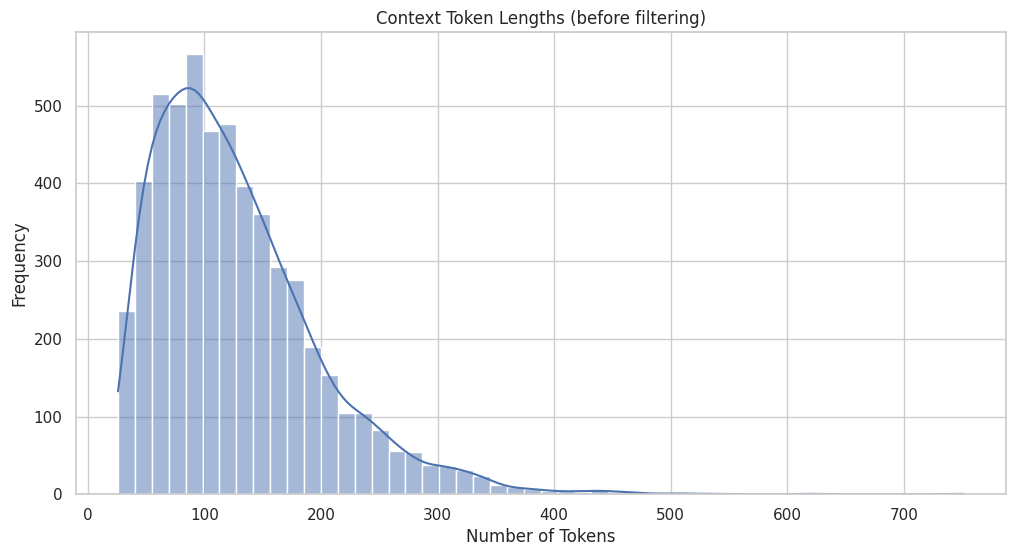

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


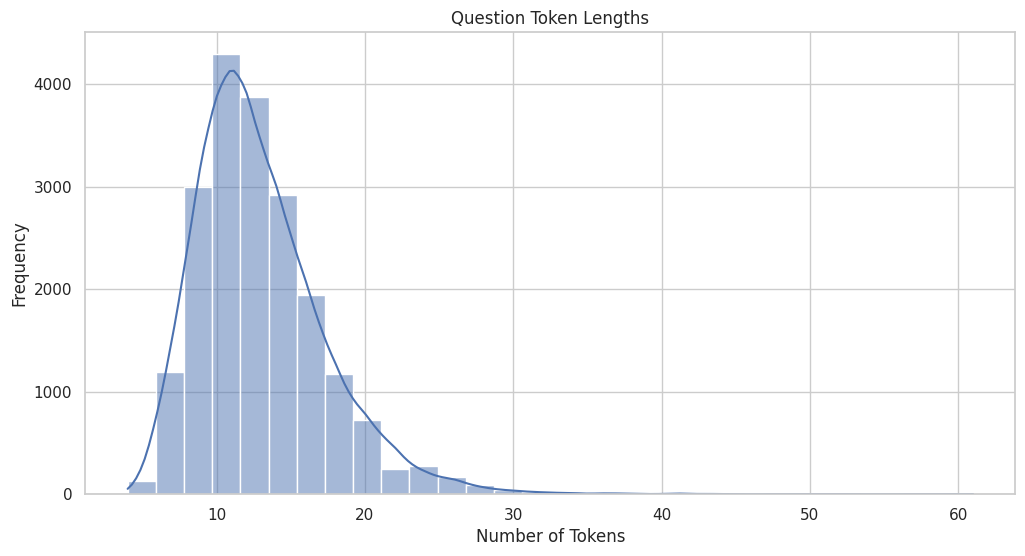

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


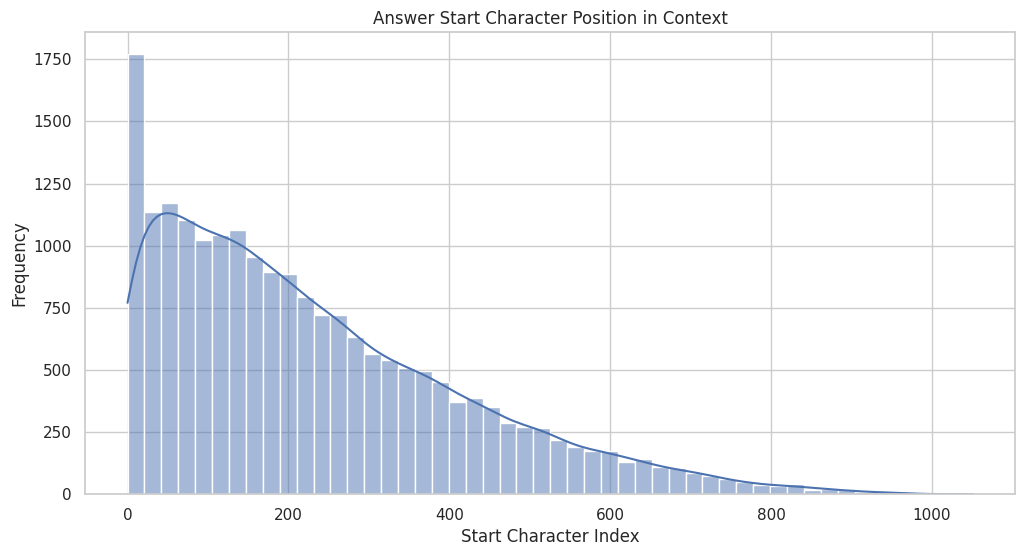

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


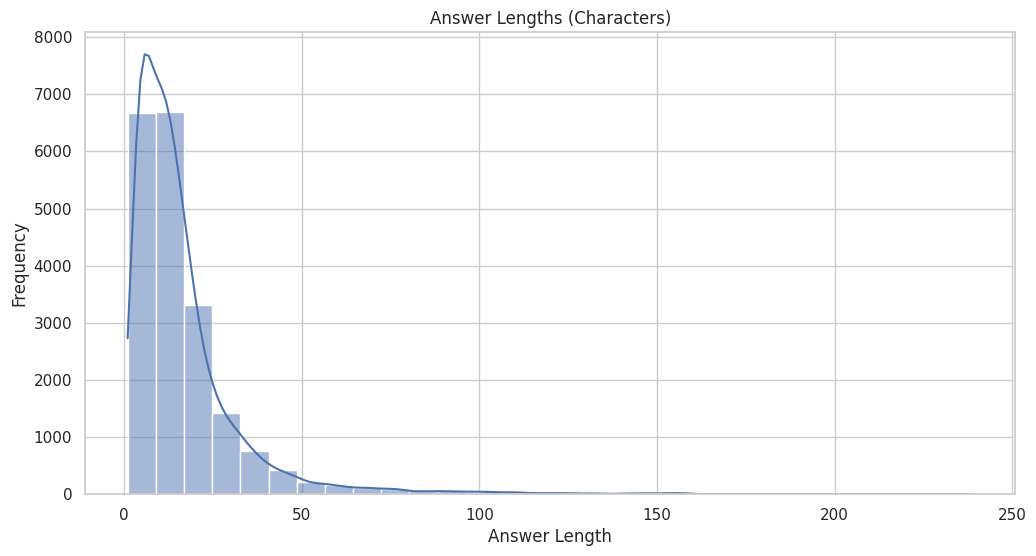

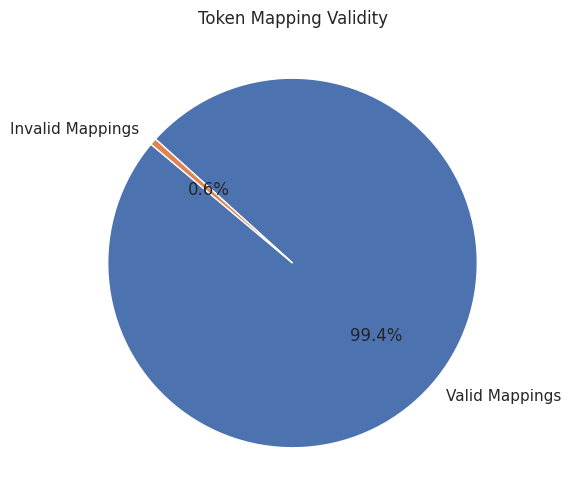

Building vocabulary...
Vocabulary size: 21370
Loading GloVe embeddings...
Embeddings loaded
Checking embedding matrix for invalid values...
NaN values: 0
Inf values: 0
Verifying training data...


100%|██████████| 16000/16000 [00:10<00:00, 1514.80it/s]


Data validation complete!


In [21]:
# Load and prepare data
print("Loading SQuAD dataset...")
samples = load_squad_subset('/kaggle/input/milestone2data/train-v1.1.json', max_samples=20000)
print(f"Loaded {len(samples)} samples")

print("Dataset insights")
plot_dataset_insights()

print("Building vocabulary...")
vocab = build_vocab(samples)
print(f"Vocabulary size: {len(vocab)}")

print("Loading GloVe embeddings...")
embedding_matrix = load_glove(vocab)
print("Embeddings loaded")

# Split data
train_samples, test_samples = train_test_split(samples, test_size=0.2, random_state=42)
train_dataset = SquadExtractiveDataset(train_samples, vocab)
test_dataset = SquadExtractiveDataset(test_samples, vocab)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Check for NaN/inf in embeddings
print("Checking embedding matrix for invalid values...")
print(f"NaN values: {torch.isnan(embedding_matrix).sum().item()}")
print(f"Inf values: {torch.isinf(embedding_matrix).sum().item()}")
assert not torch.isnan(embedding_matrix).any(), "Embeddings contain NaN values!"
assert not torch.isinf(embedding_matrix).any(), "Embeddings contain Inf values!"

# Verify all token indices are within bounds
print("Verifying training data...")
max_token_id = len(vocab) - 1
for i in tqdm(range(len(train_dataset))):
    x, _, _ = train_dataset[i]
    assert torch.all(x >= 0), f"Negative token ID found in sample {i}"
    assert torch.all(x <= max_token_id), f"Token ID exceeds vocab size in sample {i}"
print("Data validation complete!")

assert embedding_matrix.shape[0] == len(vocab), "Embedding matrix size doesn't match vocabulary!"
model = ExtractiveQARNN(
    vocab_size=len(vocab),
    emb_dim=300,
    hidden_dim=512,
    embedding_matrix=embedding_matrix.to(device),  # Initialize on CPU first
    dropout=0.7
)


In [22]:
model = safe_to_device(model, device) 
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

criterion = nn.CrossEntropyLoss()

# Training loop
train_losses, train_accs, train_f1s = [], [], []
val_losses, val_accs, val_f1s = [], [], []

best_val_loss = float('inf')
best_val_f1 = 0
patience = 4
patience_counter = 0

num_epochs = 20
print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = evaluate(model, test_loader, criterion, device)
    
    
    # Append for later plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    
    # Logging
    print(f"\nEpoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} ")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val   F1: {val_f1:.4f} " )

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("  Saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("  Early stopping triggered")
            break


Attempting to move model to cuda...
Model successfully moved to device
Starting training for 20 epochs...


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.57it/s]



Epoch 1:
  Train Loss: 8.2228 | Train Acc: 0.0127 | Train F1: 0.0611 
  Val Loss: 7.3980 | Val Acc: 0.0398 | Val   F1: 0.0863 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.50it/s]



Epoch 2:
  Train Loss: 7.5482 | Train Acc: 0.0307 | Train F1: 0.0775 
  Val Loss: 7.3492 | Val Acc: 0.0532 | Val   F1: 0.0953 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.50it/s]



Epoch 3:
  Train Loss: 7.3113 | Train Acc: 0.0436 | Train F1: 0.0863 
  Val Loss: 7.0478 | Val Acc: 0.0542 | Val   F1: 0.0941 


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.50it/s]



Epoch 4:
  Train Loss: 7.1017 | Train Acc: 0.0544 | Train F1: 0.1005 
  Val Loss: 6.7399 | Val Acc: 0.0900 | Val   F1: 0.1351 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.51it/s]



Epoch 5:
  Train Loss: 6.7057 | Train Acc: 0.0786 | Train F1: 0.1335 
  Val Loss: 6.4384 | Val Acc: 0.0943 | Val   F1: 0.1488 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s]



Epoch 6:
  Train Loss: 6.3943 | Train Acc: 0.0999 | Train F1: 0.1580 
  Val Loss: 6.1906 | Val Acc: 0.1165 | Val   F1: 0.1764 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s]



Epoch 7:
  Train Loss: 6.1020 | Train Acc: 0.1199 | Train F1: 0.1819 
  Val Loss: 6.0891 | Val Acc: 0.1232 | Val   F1: 0.1868 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s]



Epoch 8:
  Train Loss: 5.9078 | Train Acc: 0.1325 | Train F1: 0.1986 
  Val Loss: 5.8763 | Val Acc: 0.1368 | Val   F1: 0.1971 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.50it/s]



Epoch 9:
  Train Loss: 5.7202 | Train Acc: 0.1461 | Train F1: 0.2140 
  Val Loss: 5.8232 | Val Acc: 0.1470 | Val   F1: 0.2075 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.51it/s]



Epoch 10:
  Train Loss: 5.5557 | Train Acc: 0.1597 | Train F1: 0.2301 
  Val Loss: 5.7708 | Val Acc: 0.1452 | Val   F1: 0.2072 


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s]



Epoch 11:
  Train Loss: 5.3627 | Train Acc: 0.1756 | Train F1: 0.2514 
  Val Loss: 5.7440 | Val Acc: 0.1525 | Val   F1: 0.2125 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s]



Epoch 12:
  Train Loss: 5.1891 | Train Acc: 0.1862 | Train F1: 0.2631 
  Val Loss: 5.6902 | Val Acc: 0.1608 | Val   F1: 0.2247 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.51it/s]



Epoch 13:
  Train Loss: 5.0292 | Train Acc: 0.2033 | Train F1: 0.2821 
  Val Loss: 5.5278 | Val Acc: 0.1663 | Val   F1: 0.2333 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:13<00:00,  4.50it/s]



Epoch 14:
  Train Loss: 4.8561 | Train Acc: 0.2204 | Train F1: 0.3038 
  Val Loss: 5.6722 | Val Acc: 0.1595 | Val   F1: 0.2251 


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.50it/s]



Epoch 15:
  Train Loss: 4.6739 | Train Acc: 0.2320 | Train F1: 0.3159 
  Val Loss: 5.7013 | Val Acc: 0.1547 | Val   F1: 0.2200 


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s]



Epoch 16:
  Train Loss: 4.5018 | Train Acc: 0.2541 | Train F1: 0.3431 
  Val Loss: 5.6138 | Val Acc: 0.1777 | Val   F1: 0.2430 
  Saved best model


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s]



Epoch 17:
  Train Loss: 4.3126 | Train Acc: 0.2737 | Train F1: 0.3626 
  Val Loss: 5.7684 | Val Acc: 0.1643 | Val   F1: 0.2337 


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.47it/s]



Epoch 18:
  Train Loss: 4.0947 | Train Acc: 0.2912 | Train F1: 0.3837 
  Val Loss: 5.7724 | Val Acc: 0.1720 | Val   F1: 0.2394 


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s]



Epoch 19:
  Train Loss: 3.9184 | Train Acc: 0.3065 | Train F1: 0.4009 
  Val Loss: 5.9091 | Val Acc: 0.1752 | Val   F1: 0.2412 


Evaluating: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s]


Epoch 20:
  Train Loss: 3.7029 | Train Acc: 0.3321 | Train F1: 0.4278 
  Val Loss: 6.0386 | Val Acc: 0.1585 | Val   F1: 0.2303 
  Early stopping triggered


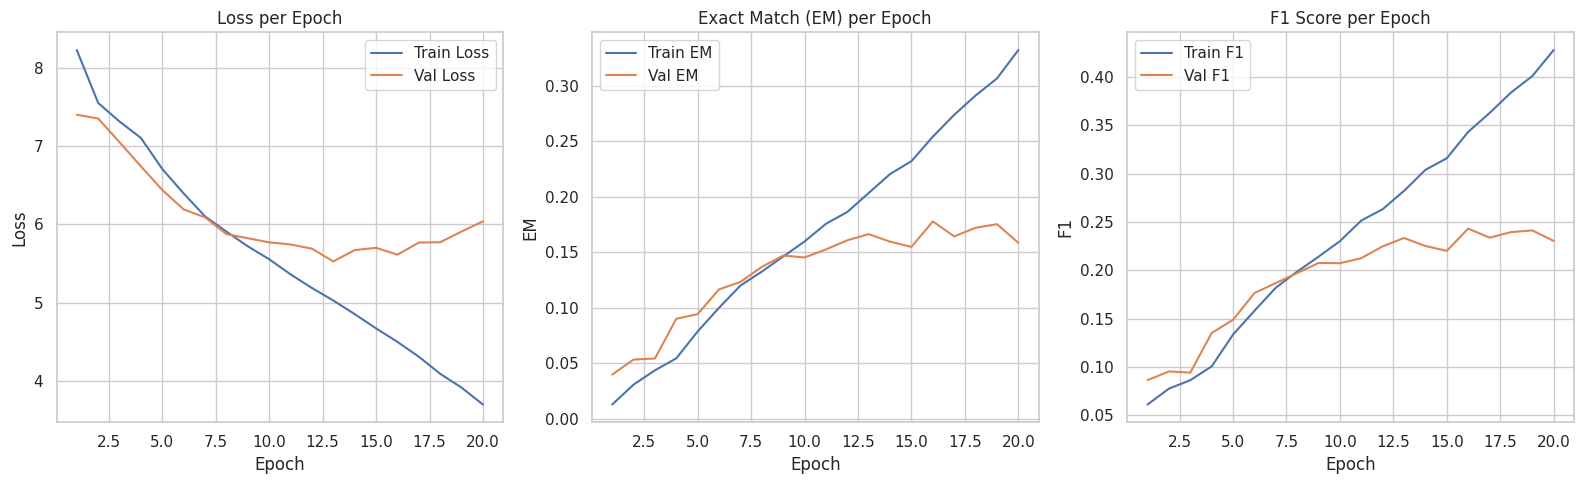

In [23]:
plot_training_progress(train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s)


In [24]:
print(f"Train loss : {train_losses} - Validation loss : {val_losses}")
print(f"Train Em : {train_accs} - Validation Em : {val_accs}")
print(f"Train F1 : {train_f1s} - Validation F1 : {val_f1s}")

Train loss : [8.222839614868164, 7.548209434509277, 7.311291749954224, 7.101671096801758, 6.705661483764649, 6.394311092376709, 6.1019663238525395, 5.907833990097046, 5.7201969509124755, 5.555710374832153, 5.362719091415405, 5.189054605484009, 5.029177440643311, 4.856104173660278, 4.673936727523803, 4.501810840606689, 4.312577960014344, 4.0946935338973995, 3.918436346054077, 3.702938377380371] - Validation loss : [7.398015468839615, 7.349222221071758, 7.047839581020295, 6.739898568107968, 6.438442381601485, 6.19061595674545, 6.089119063483344, 5.876316653357612, 5.823230592031328, 5.770814441499256, 5.743957148657905, 5.69019597674173, 5.527811610509479, 5.672174862452915, 5.701303656139071, 5.613759623633491, 5.768401077815464, 5.772383962358747, 5.909117161281525, 6.0386401206728015]
Train Em : [0.01275, 0.0306875, 0.0435625, 0.054375, 0.078625, 0.0999375, 0.1199375, 0.1325, 0.1460625, 0.1596875, 0.1755625, 0.18625, 0.2033125, 0.2204375, 0.232, 0.2540625, 0.27375, 0.2911875, 0.3065, 

In [25]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
 
# Example predictions with indices
print("\nExample Predictions:")
for i, (context, question, true_start, true_end, answer_start_char, answer_end_char) in enumerate(test_samples[:15]):
    # Get true answer info
    true_answer = extract_answer_with_indices(context, true_start, true_end)

    # Get predicted answer
    result = predict_answer_with_char_span(model, question, context, vocab, device)

    print(f"\nExample {i+1}:")
    print(f"Question: {question}")
    print(f"Context: {context[:100]}...")  # Print first 100 chars of context

    print("\nTrue Answer:")
    print(f"  Start index: {true_answer['start_idx']}")
    print(f"  End index: {true_answer['end_idx']}")
    print(f"  Char span: {answer_start_char}–{answer_end_char}")
    print(f"  Answer: {true_answer['answer_text']}")

    print("\nPredicted Answer:")
    print(f"  Start index: {result['pred_start_token']}")
    print(f"  End index: {result['pred_end_token']}")
    print("  Char span:", result['char_start'], "-", result['char_end'])
    print("  Answer:", result['answer_text'])

    print("\n" + "="*80 + "\n")


Example Predictions:


/tmp/ipykernel_85/1605025387.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Example 1:
Question: Who benefited from the demotion of Malenkov?
Context: On February 8, 1955, Malenkov was officially demoted to deputy Prime Minister. As First Secretary of...

True Answer:
  Start index: 31
  End index: 36
  Char span: 147–164
  Answer: Nikita Khrushchev

Predicted Answer:
  Start index: 27
  End index: 30
  Char span: 126 - 146
  Answer: the Communist Party,



Example 2:
Question: What was the theme song for the James Bond film Spectre?
Context: Spectre was released on 26 October 2015 in the United Kingdom on the same night as the world premier...

True Answer:
  Start index: 121
  End index: 126
  Char span: 575–596
  Answer: Writing's on the Wall

Predicted Answer:
  Start index: 40
  End index: 53
  Char span: 190 - 259
  Answer: the United States on 6 November 2015. It became the second James Bond



Example 3:
Question: Which tribes brought down the Western Roman Empire?
Context: The Roman Empire came to dominate the entire Mediterranean basin in a vast emp